<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Tf_Blood_Cell_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.3

In [ ]:
import zipfile

path = "/content/drive/MyDrive/dataset2-master.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.3.0


In [ ]:
nb_classes = 4
batch_size = 32
img_size = 224
epochs = 10
seed = 123

In [ ]:
path_train = '/content/dataset2-master/images/TRAIN'
path_val = '/content/dataset2-master/images/TEST'
path_test = '/content/dataset2-master/images/TEST_SIMPLE'

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [ ]:
images, labels = next(train_generator.flow_from_directory(path_train, target_size=(224, 224), batch_size=batch_size))

Found 9957 images belonging to 4 classes.


In [ ]:
images_val, labels_val = next(val_generator.flow_from_directory(path_val, target_size=(224, 224), batch_size=batch_size))

Found 2487 images belonging to 4 classes.


In [ ]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 224, 224, 3)
float32 (32, 4)


In [ ]:
print(images_val.dtype, images_val.shape)
print(labels_val.dtype, labels_val.shape)

float32 (32, 224, 224, 3)
float32 (32, 4)


In [ ]:
class_names = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

Found 9957 images belonging to 4 classes.


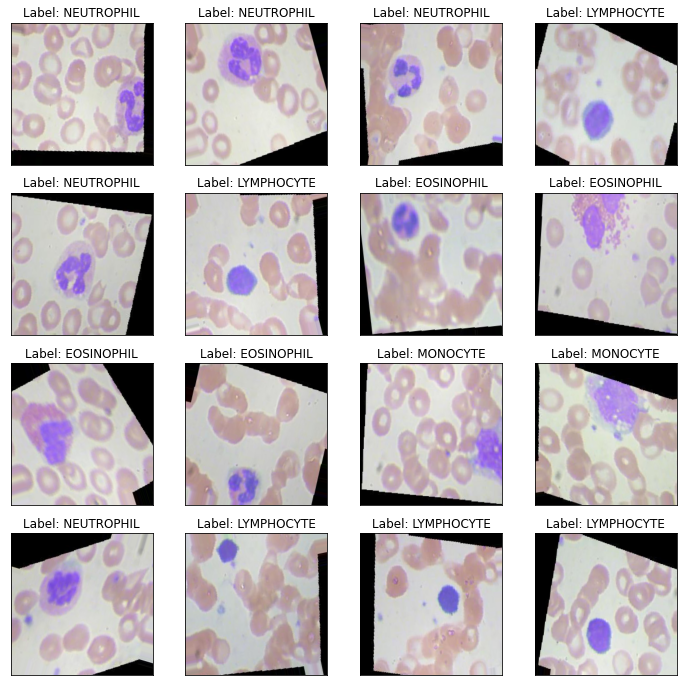

In [ ]:
def view_image(path):
    image, label = next(train_generator.flow_from_directory(path)) # extract 1 batch from the dataset
 
    fig = plt.figure(figsize=(12, 12))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {class_names[label[i].argmax()]}")
 
view_image(path_train)

In [ ]:
ds_train = tf.data.Dataset.from_generator(
    lambda: train_generator.flow_from_directory(path_train, target_size=(224, 224), batch_size=batch_size), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,224,224,3], [None,4])
)

ds_train.element_spec

ds_val = tf.data.Dataset.from_generator(
    lambda: val_generator.flow_from_directory(path_val, target_size=(224, 224), batch_size=batch_size), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,224,224,3], [None,4])
)

ds_val.element_spec

ds_test = tf.data.Dataset.from_generator(
    lambda: test_generator.flow_from_directory(path_test, target_size=(224, 224), batch_size=batch_size), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,224,224,3], [None,4])
)

ds_test.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))

In [ ]:
LR_START = 0.00001
LR_MAX = 0.0001
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

Learning rate schedule: 1e-05 to 6.4e-05 to 6.4e-05


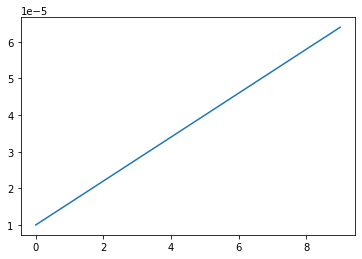

In [ ]:
def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
    lr = LR_MAX
  else:
    lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
  return lr 

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(epochs)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn

In [ ]:
def get_model():
    base_model = efn.EfficientNetB4(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False, pooling='avg')
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    outputs = tf.keras.layers.Dense(nb_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model = get_model()
    
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1836032   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 19,513,948
Trainable params: 19,388,748
Non-trainable params: 125,200
_________________________________________________________________


In [ ]:
history = model.fit(
    ds_train, 
    steps_per_epoch = 9957 // batch_size,
    callbacks=[lr_callback],
    epochs=epochs,
    validation_steps = 2487 // batch_size,
    validation_data=ds_val)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
Found 9957 images belonging to 4 classes.
311/311 [==============================] - 370s 1s/step - loss: 0.5570 - categorical_accuracy: 0.7734 - val_loss: 0.7927 - val_categorical_accuracy: 0.7666

Epoch 00002: LearningRateScheduler reducing learning rate to 1.6000000000000003e-05.
Epoch 2/10
311/311 [==============================] - 369s 1s/step - loss: 0.0631 - categorical_accuracy: 0.9763 - val_loss: 1.2258 - val_categorical_accuracy: 0.7800

Epoch 00003: LearningRateScheduler reducing learning rate to 2.2e-05.
Epoch 3/10
311/311 [==============================] - 366s 1s/step - loss: 0.0215 - categorical_accuracy: 0.9928 - val_loss: 1.7158 - val_categorical_accuracy: 0.7658

Epoch 00004: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
Epoch 4/10
311/311 [==============================] - 367s 1s/step - loss: 0.0137 - categorical_accuracy: 0.9947 - val_loss: 1.6312 - val_categor